In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('../') # add the root folder to the path

from diffusion_model.backward_module import BackwardModule
from diffusion_model.forward_module import ForwardModule
from diffusion_model.embeddings import MLPEmbedding, LinearEmbedding
from diffusion_model.scheduler import Scheduler
from diffusion_model.models import UNetNoiseModel
from diffusion_model.datasets import get_mnist_dataset
from diffusion_model.constants import device

import numpy as np
import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset

from einops import rearrange

import matplotlib.pyplot as plt
import matplotlib

In [3]:
FIG_SIZE = 4
matplotlib.rcParams['figure.figsize'] = (FIG_SIZE, FIG_SIZE)

# Datasets

Dataset shape: torch.Size([1000, 28, 28])


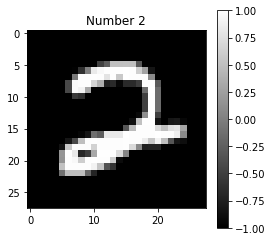

In [4]:
N_SAMPLES = 1000

dataset, labels = get_mnist_dataset(N_SAMPLES)
dim = tuple(dataset[0].shape)
flattened_dim = np.prod(dim)

plt.imshow(dataset[0].cpu(), cmap="gray")
plt.title(f"Number {labels[0]}")
plt.colorbar();
print(f"Dataset shape: {dataset.shape}")

In [5]:
print(f"Using device: {device}")

Using device: cuda


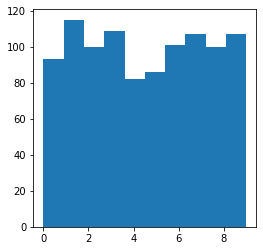

In [6]:
plt.hist(labels.cpu(), bins=10);

# Plot helpers

In [7]:
def plot_evolutions(xs_t, y_title=None, title=None):
    fig, axes = plt.subplots(1, len(xs_t), figsize=(FIG_SIZE*len(xs_t), FIG_SIZE))
    if title is not None:
        fig.suptitle(title)
    if y_title is not None:
        axes[0].set_ylabel(y_title)
    for i, ax in enumerate(axes):
        progress = i / (len(xs_t)-1)
        ax.imshow(xs_t[i].cpu(), cmap='gray')
        ax.set_title(f"t={progress*100:.0f}%")
    plt.show()

# Embeddings

In [8]:
def check_embedding(base, embedding_model):
    with torch.no_grad():
        base = base.to(device)
        embedded_base = embedding_model(base).detach().cpu()
    for v in embedded_base:
        assert ((-1 <= v) & (v <= 1)).all(), "Embedding should be in [-1, 1]"

    n = len(base)
    dist_matrix = torch.zeros((n, n))
    for i in range(n):
        for j in range(n):
            dist_matrix[i, j] = torch.norm(embedded_base[i] - embedded_base[j])
    plt.title("Distance matrix")
    plt.imshow(dist_matrix, cmap='gray')
    plt.colorbar()

In [9]:
x = torch.ones((2, 64, 28, 28))
t = torch.ones((2, 64))
t = rearrange(t, "n c -> n c 1 1")
# t = t[(...,) +(None,)*2]
print(x.shape, t.shape)
(x + t)[0].shape

torch.Size([2, 64, 28, 28]) torch.Size([2, 64, 1, 1])


torch.Size([64, 28, 28])

In [10]:
t = 

SyntaxError: invalid syntax (3175700322.py, line 1)

## Label embedding

100%|█████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 70.08it/s]


Loss: 0.18008925020694733


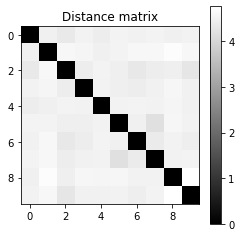

In [ ]:
label_embedding = MLPEmbedding(10, flattened_dim)

def one_hot_label(label):
    label = torch.eye(10)[label].float().to(device)
    label = rearrange(label, "d -> 1 d")
    return label

labels_one_hot = F.one_hot(labels, 10).float()
label_dataloader = DataLoader(labels_one_hot, batch_size=256, shuffle=True)
loss = label_embedding.fit(label_dataloader, nb_epochs=20)
print(f"Loss: {loss}")

check_embedding(torch.eye(10), label_embedding)

## Time steps embedding

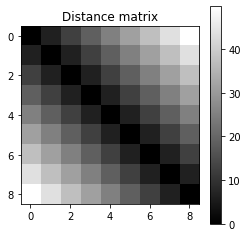

In [13]:
T = 10

time_embedding = LinearEmbedding(flattened_dim, 0, T-1)

check_embedding(torch.arange(0, T-1), time_embedding)

# Diffusion model

## Scheduler

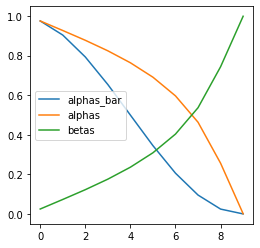

In [54]:
scheduler = Scheduler(input_dim=dim, nb_steps=T, schedule_type="cosine")

plt.plot(scheduler.alphas_bar.cpu()[:, 0, 0], label="alphas_bar")
plt.plot(scheduler.alphas.cpu()[:, 0, 0], label="alphas")
plt.plot(scheduler.betas.cpu()[:, 0, 0], label="betas")
plt.legend();

In [15]:
print(f"beta: min={scheduler.betas.min().item()}, max={scheduler.betas.max().item()}")

beta: min=0.009999990463256836, max=0.9990000128746033


## Modules and model

In [60]:
forward_module = ForwardModule(scheduler=scheduler)
noise_model = UNetNoiseModel(forward_module=forward_module, scheduler=scheduler)
backward_module = BackwardModule(forward_module=forward_module, scheduler=scheduler, noise_model=noise_model)

V15


## Forward

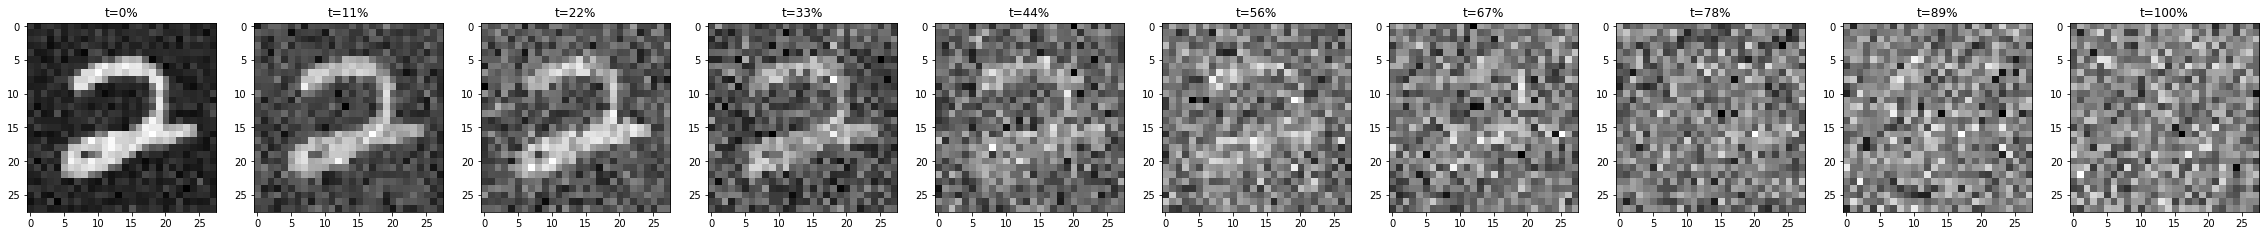

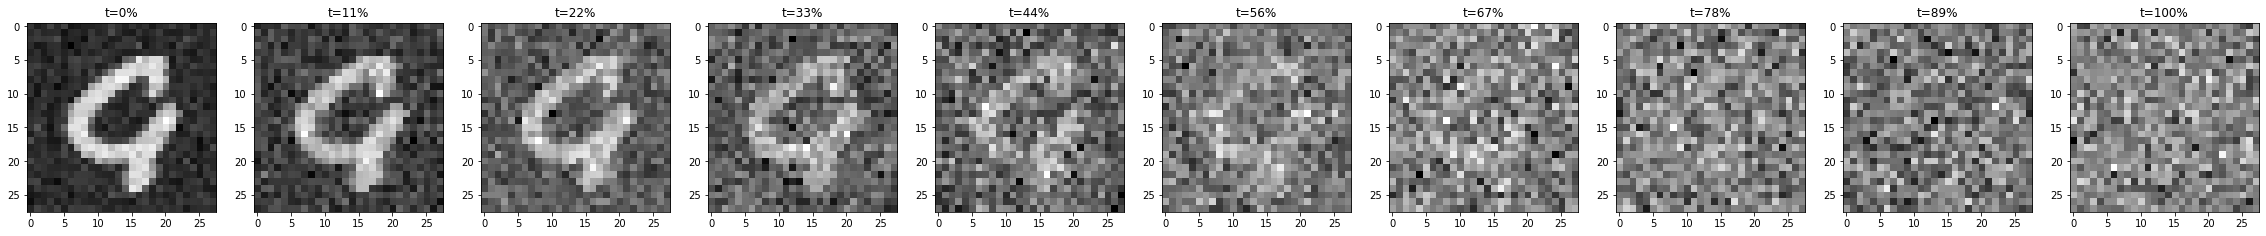

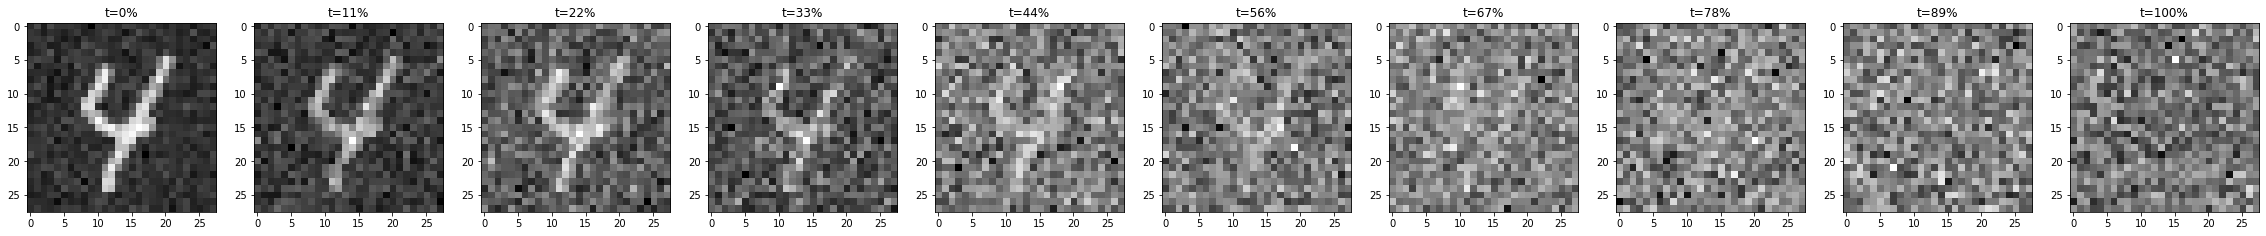

In [56]:
NB_DISPLAYED = 10
NB_EXAMPLES = 3

xs = dataset[:NB_EXAMPLES]
xs = forward_module.loop_forward(xs, nb_displayed_steps=NB_DISPLAYED)
xs = rearrange(xs, "t n h w -> n t h w")
for x in xs:
    plot_evolutions(x)

## Train the noise model

  0%|                                                                                            | 0/1000 [00:00<?, ?it/s]

down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

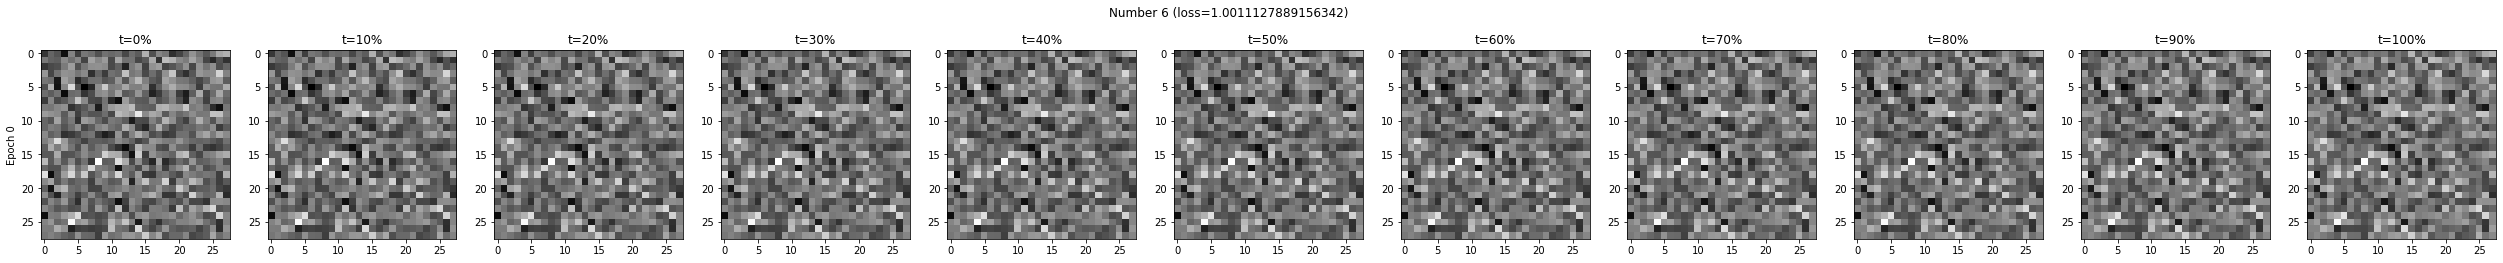

  0%|▏                                                                                   | 2/1000 [00:01<10:45,  1.55it/s]

down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

  0%|▎                                                                                   | 4/1000 [00:01<04:55,  3.37it/s]

down[1] torch.Size([232, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 32, 14, 14])
down[1] torch.Size([232, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 64, 7, 7])
down[1] torch.Size([232, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

  1%|▌                                                                                   | 6/1000 [00:02<03:17,  5.03it/s]

down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

  1%|▌                                                                                   | 7/1000 [00:02<02:55,  5.66it/s]

down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

  1%|▊                                                                                   | 9/1000 [00:02<02:30,  6.57it/s]

down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

  1%|▉                                                                                  | 11/1000 [00:02<02:10,  7.56it/s]

down[1] torch.Size([232, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 32, 14, 14])
down[1] torch.Size([232, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 64, 7, 7])
down[1] torch.Size([232, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

  1%|█                                                                                  | 13/1000 [00:02<02:06,  7.80it/s]

down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

  1%|█▏                                                                                 | 14/1000 [00:03<02:04,  7.95it/s]

down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

  2%|█▎                                                                                 | 16/1000 [00:03<02:04,  7.87it/s]

down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

  2%|█▍                                                                                 | 18/1000 [00:03<02:01,  8.09it/s]

act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform ConvTranspose2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
up[1] torch.Size([232, 128, 14, 14]) torch.Size([232, 64, 14, 14])
conv Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform ConvTranspose2d(32, 32, kernel_size=(2, 2), stride=(2, 2))
up[2] torch.Size([232, 32, 28, 28]) torch.Size([232, 64, 14, 14])
down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_s

  2%|█▋                                                                                 | 20/1000 [00:03<02:02,  8.01it/s]

down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

  2%|█▋                                                                                 | 21/1000 [00:03<02:00,  8.12it/s]

down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

  2%|█▉                                                                                 | 23/1000 [00:04<02:02,  8.00it/s]

down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

  2%|██                                                                                 | 25/1000 [00:04<02:04,  7.86it/s]

down[1] torch.Size([232, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 32, 14, 14])
down[1] torch.Size([232, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 64, 7, 7])
down[1] torch.Size([232, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

  3%|██▏                                                                                | 27/1000 [00:04<02:00,  8.06it/s]

down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

  3%|██▎                                                                                | 28/1000 [00:04<01:59,  8.12it/s]

down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

  3%|██▍                                                                                | 30/1000 [00:05<02:00,  8.04it/s]

down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

  3%|██▋                                                                                | 32/1000 [00:05<02:02,  7.92it/s]

down[1] torch.Size([232, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 32, 14, 14])
down[1] torch.Size([232, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 64, 7, 7])
down[1] torch.Size([232, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

  3%|██▊                                                                                | 34/1000 [00:05<01:57,  8.19it/s]

down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

  4%|██▉                                                                                | 35/1000 [00:05<02:01,  7.91it/s]

down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

  4%|███                                                                                | 37/1000 [00:05<02:00,  7.97it/s]

down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

  4%|███▏                                                                               | 39/1000 [00:06<01:59,  8.07it/s]

down[1] torch.Size([232, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 32, 14, 14])
down[1] torch.Size([232, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 64, 7, 7])
down[1] torch.Size([232, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

  4%|███▍                                                                               | 41/1000 [00:06<01:57,  8.19it/s]

down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

  4%|███▍                                                                               | 42/1000 [00:06<01:58,  8.06it/s]

down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

  4%|███▋                                                                               | 44/1000 [00:06<01:59,  8.00it/s]

down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

  5%|███▊                                                                               | 46/1000 [00:06<01:53,  8.44it/s]

down[1] torch.Size([232, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 32, 14, 14])
down[1] torch.Size([232, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 64, 7, 7])
down[1] torch.Size([232, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

  5%|███▉                                                                               | 48/1000 [00:07<01:53,  8.36it/s]

act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform ConvTranspose2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
up[1] torch.Size([256, 128, 14, 14]) torch.Size([256, 64, 14, 14])
conv Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform ConvTranspose2d(32, 32, kernel_size=(2, 2), stride=(2, 2))
up[2] to

  5%|████                                                                               | 49/1000 [00:07<01:54,  8.28it/s]

down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

  5%|████▏                                                                              | 51/1000 [00:07<01:59,  7.94it/s]

down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

  5%|████▍                                                                              | 53/1000 [00:07<01:57,  8.08it/s]

down[1] torch.Size([232, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 32, 14, 14])
down[1] torch.Size([232, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 64, 7, 7])
down[1] torch.Size([232, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

  6%|████▌                                                                              | 55/1000 [00:08<01:55,  8.20it/s]

down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

  6%|████▋                                                                              | 56/1000 [00:08<01:57,  8.03it/s]

down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

  6%|████▊                                                                              | 58/1000 [00:08<01:57,  8.00it/s]

down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

  6%|████▉                                                                              | 60/1000 [00:08<01:56,  8.07it/s]

down[1] torch.Size([232, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 32, 14, 14])
down[1] torch.Size([232, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 64, 7, 7])
down[1] torch.Size([232, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

  6%|█████▏                                                                             | 62/1000 [00:08<01:56,  8.02it/s]

down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

  6%|█████▏                                                                             | 63/1000 [00:09<01:58,  7.93it/s]

down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

  6%|█████▍                                                                             | 65/1000 [00:09<01:59,  7.81it/s]

down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

  7%|█████▌                                                                             | 67/1000 [00:09<01:58,  7.86it/s]

down[1] torch.Size([232, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 32, 14, 14])
down[1] torch.Size([232, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 64, 7, 7])
down[1] torch.Size([232, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

  7%|█████▋                                                                             | 69/1000 [00:09<01:54,  8.12it/s]

down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

  7%|█████▊                                                                             | 70/1000 [00:09<01:53,  8.16it/s]

down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

  7%|█████▉                                                                             | 72/1000 [00:10<01:55,  8.06it/s]

down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

  7%|██████▏                                                                            | 74/1000 [00:10<01:55,  8.00it/s]

down[1] torch.Size([232, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 32, 14, 14])
down[1] torch.Size([232, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 64, 7, 7])
down[1] torch.Size([232, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

  8%|██████▎                                                                            | 76/1000 [00:10<01:58,  7.82it/s]

down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

  8%|██████▍                                                                            | 77/1000 [00:10<01:58,  7.77it/s]

down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

  8%|██████▌                                                                            | 79/1000 [00:11<01:59,  7.72it/s]

down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

  8%|██████▋                                                                            | 81/1000 [00:11<01:59,  7.69it/s]

act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform ConvTranspose2d(32, 32, kernel_size=(2, 2), stride=(2, 2))
up[2] torch.Size([256, 32, 28, 28]) torch.Size([256, 64, 14, 14])
down[1] torch.Size([232, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 32, 14, 14])
down[1] torch.Size([232, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 64, 7, 7])
down[1] torch.Size([232, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Co

  8%|██████▊                                                                            | 82/1000 [00:11<01:59,  7.70it/s]

down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

  8%|██████▉                                                                            | 84/1000 [00:11<01:56,  7.85it/s]

down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

  9%|███████▏                                                                           | 86/1000 [00:12<01:56,  7.87it/s]

down[1] torch.Size([232, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 32, 14, 14])
down[1] torch.Size([232, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 64, 7, 7])
down[1] torch.Size([232, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

  9%|███████▎                                                                           | 88/1000 [00:12<01:55,  7.90it/s]

down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

  9%|███████▍                                                                           | 89/1000 [00:12<01:57,  7.73it/s]

down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

  9%|███████▌                                                                           | 91/1000 [00:12<01:56,  7.82it/s]

down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

  9%|███████▋                                                                           | 93/1000 [00:12<01:52,  8.06it/s]

down[1] torch.Size([232, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 32, 14, 14])
down[1] torch.Size([232, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 64, 7, 7])
down[1] torch.Size([232, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

 10%|███████▉                                                                           | 95/1000 [00:13<01:52,  8.01it/s]

down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

 10%|███████▉                                                                           | 96/1000 [00:13<01:51,  8.12it/s]

down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

 10%|████████▏                                                                          | 99/1000 [00:13<01:30,  9.92it/s]

down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

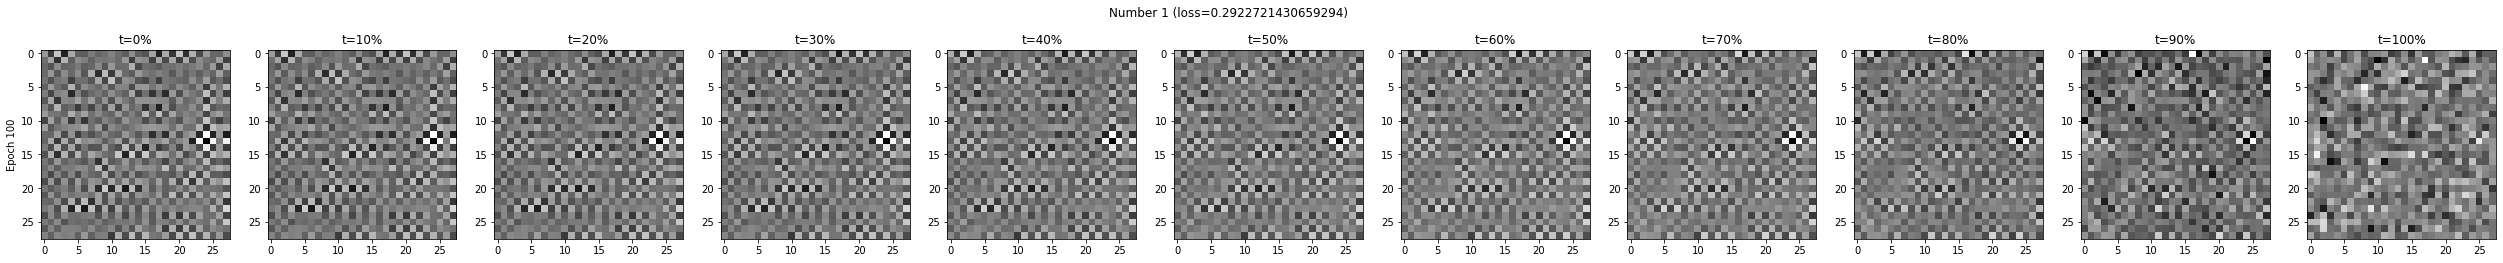

 10%|████████▍                                                                         | 103/1000 [00:15<04:07,  3.62it/s]

down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

 11%|████████▊                                                                         | 107/1000 [00:15<02:17,  6.47it/s]

down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

 11%|█████████                                                                         | 111/1000 [00:15<01:32,  9.60it/s]

down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform ConvTranspose2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
up[1] torch.Size([256, 128, 14, 14]) torch.Size([256, 64, 14, 14])
conv Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform ConvTranspose2d(32, 32, kernel_size=(2, 2), stride=(2, 2))
up[2] torch.Size([256, 32, 28, 28]) torch.Size([256, 64, 14, 14])
down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
c

 11%|█████████▎                                                                        | 113/1000 [00:15<01:19, 11.14it/s]

act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform ConvTranspose2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
up[1] torch.Size([256, 128, 14, 14]) torch.Size([256, 64, 14, 14])
conv Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform ConvTranspose2d(32, 32, kernel_size=(2, 2), stride=(2, 2))
up[2] to

 12%|█████████▌                                                                        | 117/1000 [00:16<01:04, 13.63it/s]

down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

 12%|█████████▉                                                                        | 121/1000 [00:16<00:57, 15.40it/s]

down[1] torch.Size([232, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 32, 14, 14])
down[1] torch.Size([232, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 64, 7, 7])
down[1] torch.Size([232, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

 12%|██████████▎                                                                       | 125/1000 [00:16<00:53, 16.41it/s]

act ReLU()
transform ConvTranspose2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
up[1] torch.Size([256, 128, 14, 14]) torch.Size([256, 64, 14, 14])
conv Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform ConvTranspose2d(32, 32, kernel_size=(2, 2), stride=(2, 2))
up[2] torch.Size([256, 32, 28, 28]) torch.Size([256, 64, 14, 14])
down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_s

 13%|██████████▌                                                                       | 129/1000 [00:16<00:53, 16.38it/s]

down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

 13%|██████████▋                                                                       | 131/1000 [00:17<00:52, 16.56it/s]

act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform ConvTranspose2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
up[1] torch.Size([256, 128, 14, 14]) torch.Size([256, 64, 14, 14])
conv Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform ConvTranspose2d(32, 32, kernel_size=(2, 2), stride=(2, 2))
up[2] torch.Size([256, 32, 28, 28]) torch.Size([256, 64, 14, 14])
down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

 14%|███████████                                                                       | 135/1000 [00:17<00:50, 17.22it/s]

down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

 14%|███████████▍                                                                      | 139/1000 [00:17<00:50, 16.93it/s]

down[1] torch.Size([232, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 32, 14, 14])
down[1] torch.Size([232, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 64, 7, 7])
down[1] torch.Size([232, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

 14%|███████████▋                                                                      | 143/1000 [00:17<00:51, 16.70it/s]

down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

 15%|████████████                                                                      | 147/1000 [00:17<00:51, 16.65it/s]

down[1] torch.Size([232, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 32, 14, 14])
down[1] torch.Size([232, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 64, 7, 7])
down[1] torch.Size([232, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

 15%|████████████▏                                                                     | 149/1000 [00:18<00:51, 16.52it/s]

act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform ConvTranspose2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
up[1] torch.Size([256, 128, 14, 14]) torch.Size([256, 64, 14, 14])
conv Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act Re

 15%|████████████▌                                                                     | 153/1000 [00:18<00:50, 16.71it/s]

down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

 16%|████████████▊                                                                     | 157/1000 [00:18<00:49, 17.11it/s]

down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

 16%|█████████████▏                                                                    | 161/1000 [00:18<00:50, 16.68it/s]

down[1] torch.Size([232, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 32, 14, 14])
down[1] torch.Size([232, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 64, 7, 7])
down[1] torch.Size([232, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

 16%|█████████████▎                                                                    | 163/1000 [00:18<00:50, 16.65it/s]

act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform ConvTranspose2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
up[1] torch.Size([256, 128, 14, 14]) torch.Size([256, 64, 14, 14])
conv Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform ConvTranspose2d(32, 32, kernel_size=(2, 2), stride=(2, 2))
up[2] torch.Size([256, 32, 28, 28]) torch.Size([256, 64, 14, 14])
down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

 17%|█████████████▋                                                                    | 167/1000 [00:19<00:48, 17.06it/s]

down[1] torch.Size([232, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 32, 14, 14])
down[1] torch.Size([232, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 64, 7, 7])
down[1] torch.Size([232, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

 17%|██████████████                                                                    | 171/1000 [00:19<00:49, 16.63it/s]

down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

 18%|██████████████▎                                                                   | 175/1000 [00:19<00:48, 16.94it/s]

down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

 18%|██████████████▌                                                                   | 177/1000 [00:19<00:48, 17.00it/s]

act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1)

 18%|██████████████▊                                                                   | 181/1000 [00:19<00:48, 16.98it/s]

down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

 18%|███████████████▏                                                                  | 185/1000 [00:20<00:48, 16.80it/s]

up[1] torch.Size([256, 128, 14, 14]) torch.Size([256, 64, 14, 14])
conv Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform ConvTranspose2d(32, 32, kernel_size=(2, 2), stride=(2, 2))
up[2] torch.Size([256, 32, 28, 28]) torch.Size([256, 64, 14, 14])
down[1] torch.Size([232, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 32, 14, 14])
down[1] torch.Size([232, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232

 19%|███████████████▍                                                                  | 189/1000 [00:20<00:48, 16.90it/s]

down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

 19%|███████████████▋                                                                  | 191/1000 [00:20<00:48, 16.83it/s]

down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

 20%|███████████████▉                                                                  | 195/1000 [00:20<00:47, 16.96it/s]

down[1] torch.Size([256, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 32, 14, 14])
down[1] torch.Size([256, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 64, 7, 7])
down[1] torch.Size([256, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([256, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

 20%|████████████████▎                                                                 | 199/1000 [00:21<00:46, 17.39it/s]

down[1] torch.Size([232, 1, 28, 28])
conv Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 32, 14, 14])
down[1] torch.Size([232, 32, 14, 14])
conv Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 64, 7, 7])
down[1] torch.Size([232, 64, 7, 7])
conv Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
conv Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
act ReLU()
transform MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
down[2] torch.Size([232, 128, 3, 3])
conv Conv2d(128, 64, kernel_s

In [62]:
BATCH_SIZE = 256
NB_EPOCHS = 1000

def display_evolutions(epoch, losses=None):
    loss = sum(losses) / len(losses) if losses else None
    label = torch.randint(0, 10, (1,)).to(device)
    xs_t = backward_module.loop_backward(label, n_sample=1, nb_displayed_steps=NB_DISPLAYED)
    x_t = rearrange(xs_t, "t 1 h w -> t h w")
    plot_evolutions(x_t, title=f"Number {label.item()} (loss={loss})", y_title=f"Epoch {epoch}")

X = TensorDataset(dataset, labels)
dataloader = DataLoader(X, batch_size=BATCH_SIZE)
noise_model.fit(dataloader, nb_epochs=NB_EPOCHS, logger=display_evolutions)
display_evolutions(NB_EPOCHS)

# Evaluation

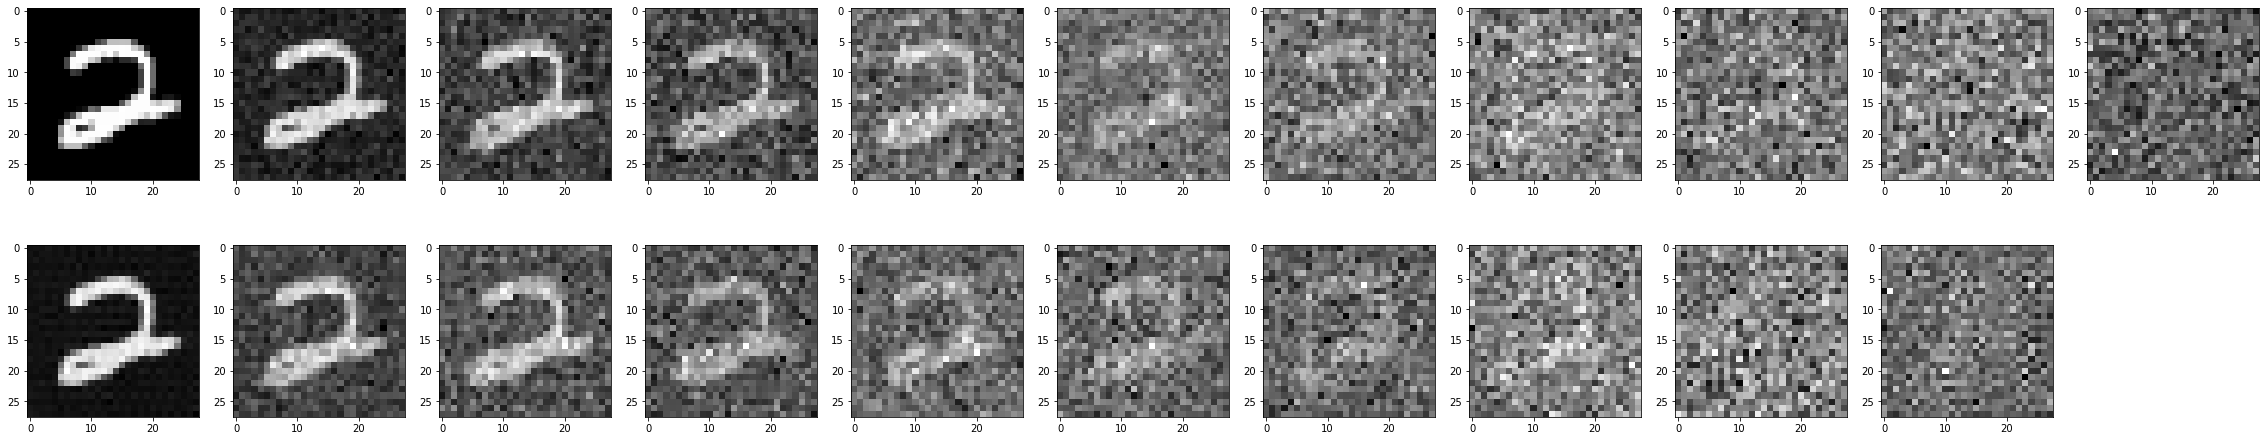

In [59]:
fig, axes = plt.subplots(2, T+1, figsize=(FIG_SIZE*T, FIG_SIZE*2))

x = rearrange(dataset[0], "h w -> 1 h w")
x_t = forward_module.loop_forward(x, nb_displayed_steps=T)
x_prev = [backward_module.batched_backward(x, t, labels[0]) for t, x in enumerate(x_t)]

x_t = rearrange(x_t, "t 1 h w -> t h w")
x_prev = rearrange(x_prev, "t 1 h w -> t h w")
x = rearrange(x, "1 h w -> h w")

axes[0, 0].imshow(x.cpu(), cmap='gray')
axes[1, -1].axis('off')
for i, ax in enumerate(axes[0, 1:]):
    ax.imshow(x_t[i].cpu(), cmap='gray')
for i, ax in enumerate(axes[1,:-1]):
    ax.imshow(x_prev[i].detach().cpu(), cmap='gray')

## Backward

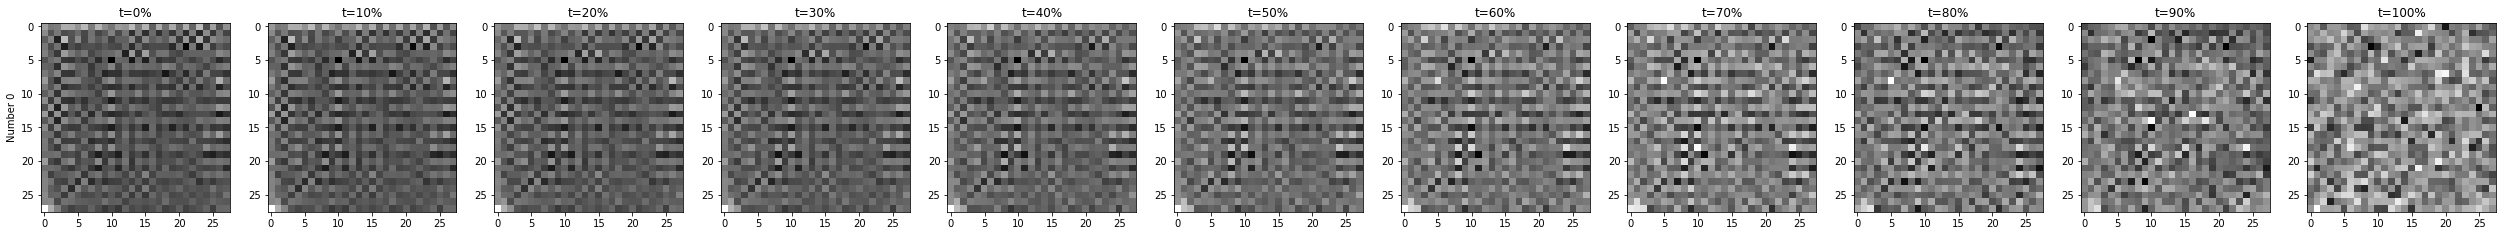

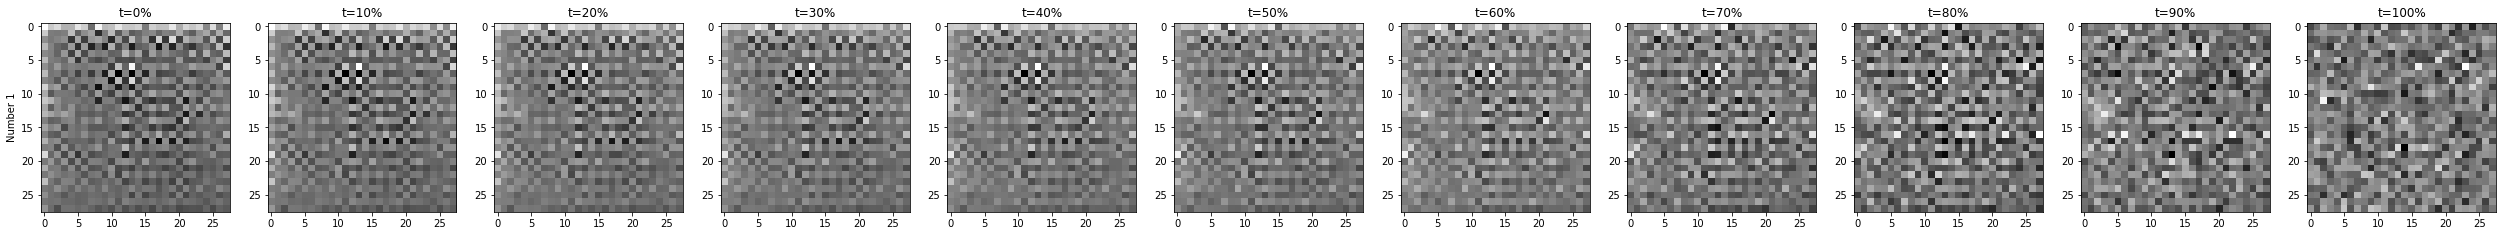

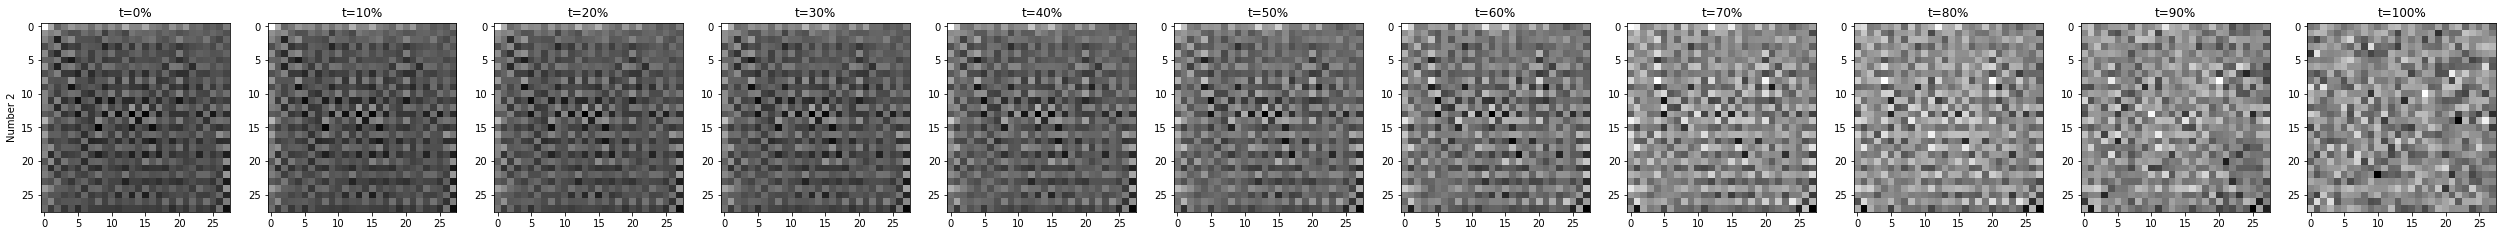

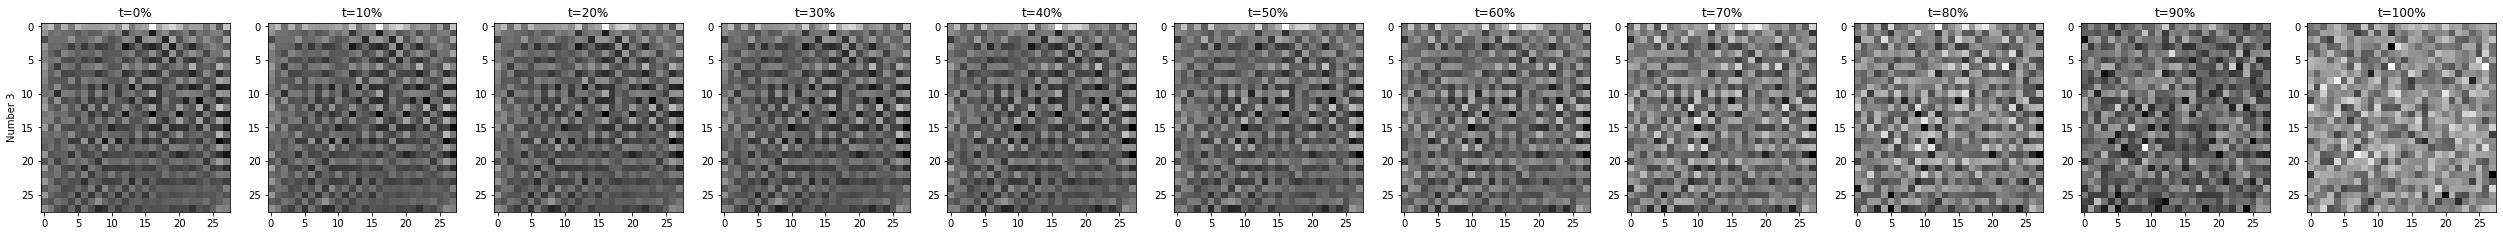

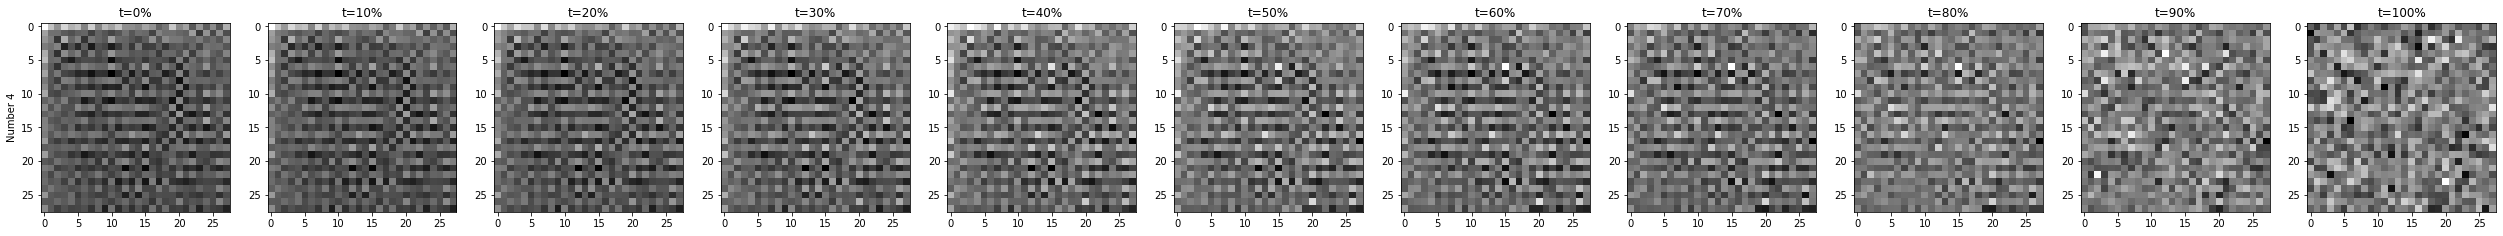

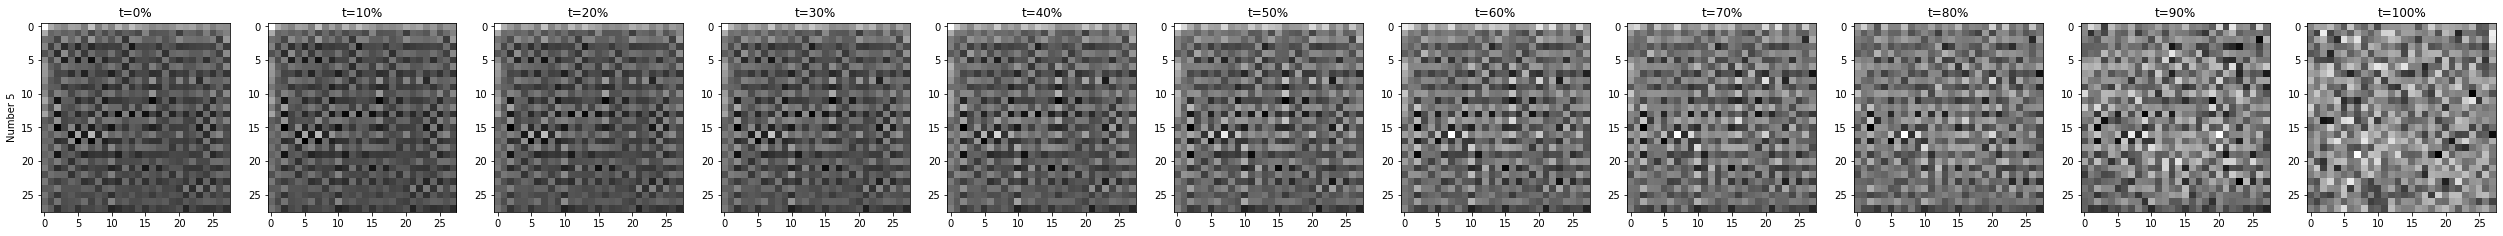

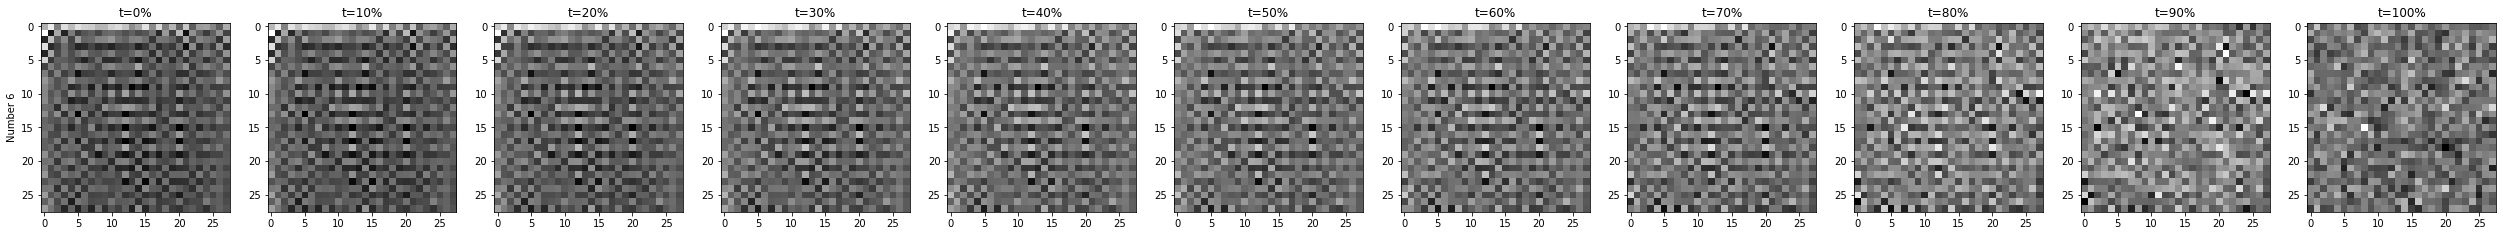

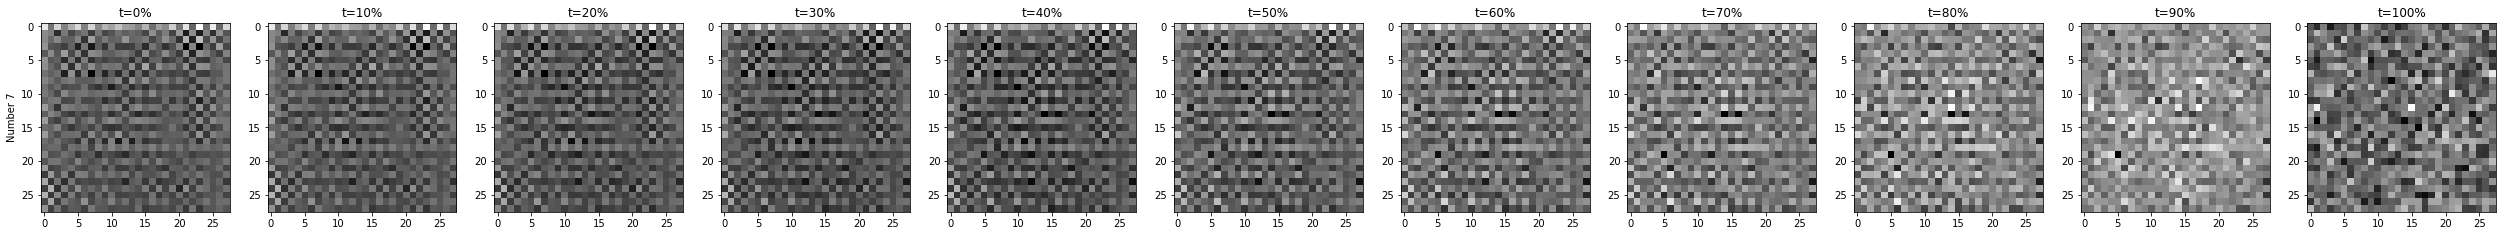

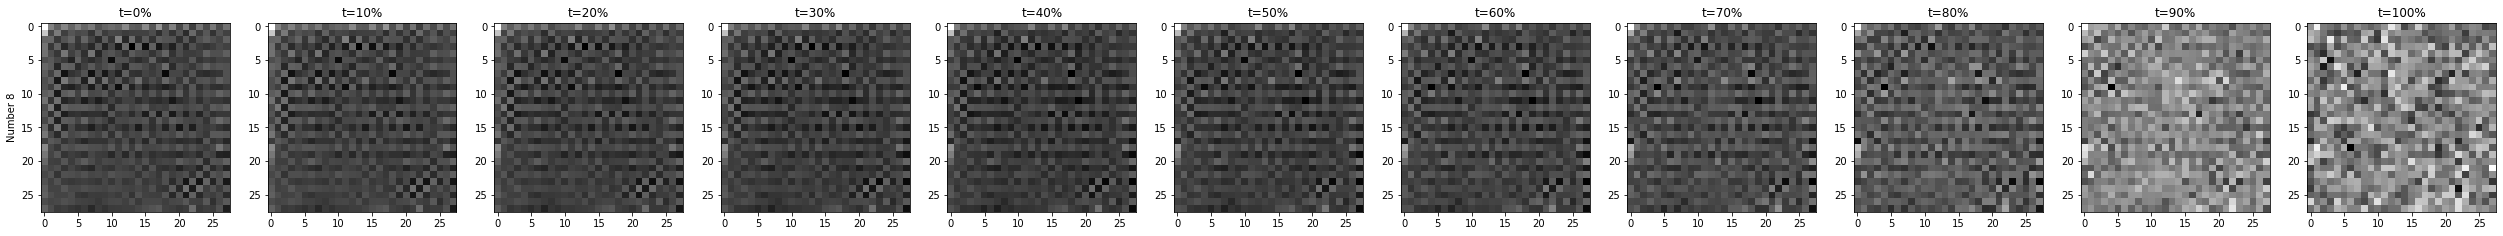

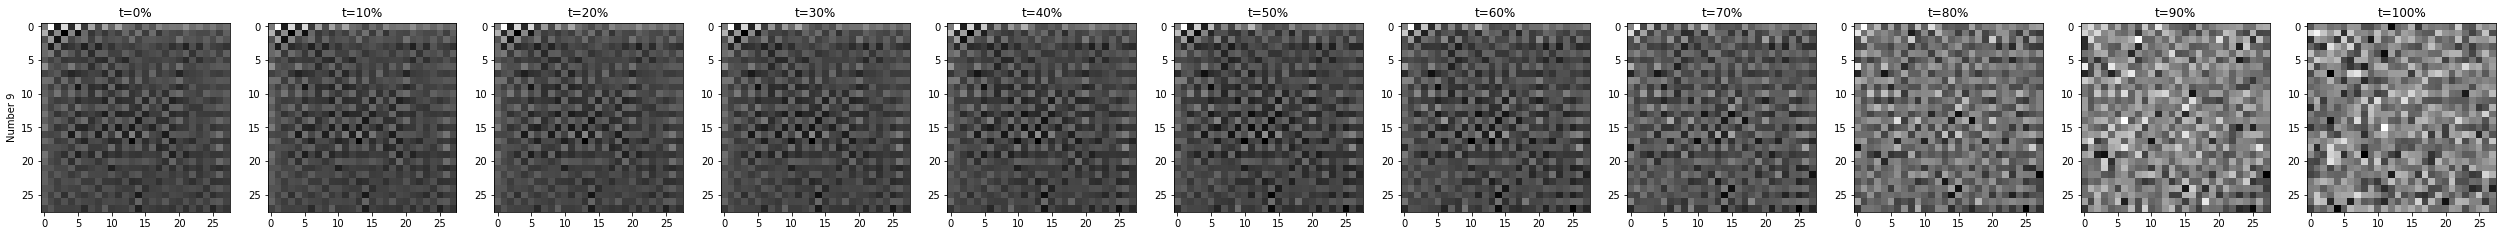

In [58]:
example_labels = rearrange(torch.arange(0, 10).to(device), "d -> d 1")
# example_labels = torch.cat([label_vec for _, label_vec in example_labels], dim=0).to(device)

xs = backward_module.loop_backward(example_labels, n_sample=10, nb_displayed_steps=NB_DISPLAYED)
xs = rearrange(xs, "t n h w -> n t h w")
for i, x in enumerate(xs):
    plot_evolutions(x, y_title=f"Number {i}")